# Code that might be useful later

## Sklearn trick for clustering strings

In [2]:
class SklearnStringTrick:
    """
    String clustering trick shown at:
        https://scikit-learn.org/0.16/faq.html#how-do-i-deal-with-string-data-or-trees-graphs

    Class structure allows for method reuse over distinct data

    """

    def __init__(self, dataset=[]):
        self.dataset = dataset

    def lev_dist_sklearn_urls(self, x, y):
        i, j = int(x[0]), int(y[0])  # extract indices
        return levenshtein(self.dataset[i], self.dataset[j])

In [3]:
string_trick = SklearnStringTrick()

## Pattern for filtering IPv6 addresses

## My attempt for regex splitting domain and subdomains

## Alternative library for tld matching

#### N-grams

#### Non-functional version of TF-IDF

Crashes on the .toarray() function
Might be memory issue?

TfidfVectorizer works though

## TF-IDF using HashingVectorizer

Not working yet

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer


class IncrementalHashingVectorizer:
    def __init__(self, n_features=2**18, ngram_range=(1, 1), **kwargs):
        self.vectorizer = HashingVectorizer(
            n_features=n_features, ngram_range=ngram_range, **kwargs
        )
        self.partial_fit_calls = 0

    def partial_fit(self, X):
        if self.partial_fit_calls == 0:
            self.features_sum = np.zeros(self.vectorizer.n_features)
            self.feature_counts = np.zeros(self.vectorizer.n_features)

        transformed = self.vectorizer.transform(X)
        self.features_sum += transformed.sum(axis=0)
        self.feature_counts += transformed.getnnz(axis=0)
        self.partial_fit_calls += 1
        return self

    def transform(self, X):
        transformed = self.vectorizer.transform(X)
        idf_vector = np.log(self.partial_fit_calls / (1 + self.feature_counts)) + 1
        return transformed.multiply(idf_vector)


incremental_vectorizer = IncrementalHashingVectorizer(
    ngram_range=NGRAM_RANGE, analyzer="char"
)


incremental_vectorizer.partial_fit([doc])

transformed_documents = incremental_vectorizer.transform(documents)

## TF-IDF on batches

In [ ]:
# Create TfidfVectorizer instance for domain column
tfidf_domain = TfidfVectorizer(analyzer="char", ngram_range=NGRAM_RANGE)
# Fit and transform domain column
tfidf_domain_matrix = tfidf_domain.fit_transform(urls_df["domain"])

# Create TfidfVectorizer instance for subdomain column
tfidf_subdomain = TfidfVectorizer(analyzer="char", ngram_range=NGRAM_RANGE)
# Fit and transform subdomain column
tfidf_subdomain_matrix = tfidf_subdomain.fit_transform(urls_df["subdomain"])

# Create pandas dataframe from tfidf_matrix
tfidf_domain_df_tfidfv = pd.DataFrame(
    tfidf_domain_matrix.toarray(),
    columns=tfidf_domain.get_feature_names_out(),
    index=urls_df.index,
)
tfidf_subdomain_df_tfidfv = pd.DataFrame(
    tfidf_subdomain_matrix.toarray(),
    columns=tfidf_subdomain.get_feature_names_out(),
    index=urls_df.index,
)

# Concatenate the dataframes
# tfidf_df = pd.concat([tfidf_domain_df, tfidf_subdomain_df], axis=1)

In [ ]:
tfidf_domain_df_tfidfv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638971 entries, 0 to 638970
Columns: 165105 entries, '01 to zzzi
dtypes: float64(165105)
memory usage: 786.0 GB


In [ ]:
tfidf_subdomain_df_tfidfv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638971 entries, 0 to 638970
Columns: 162855 entries, '00 to zzzz
dtypes: float64(162855)
memory usage: 775.3 GB


## How to use LSA for TF-IDF

In [27]:
# Taken from https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#performing-dimensionality-reduction-using-lsa

lsa = make_pipeline(TruncatedSVD(n_components=10), Normalizer(copy=False))

X_domain_lsa = lsa.fit_transform(X_domain_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Explained variance of the SVD step: 49.2%


### Attempts at parallelising the finding of optimal truncate ratio

In the end I decided to subsample

Might be useful in future development

The main issue: Threads copy _as I currently believe_ the whole dataset into their processing space. Since the matrix is large it takes a bunch of memory.

Possible solutions: 
- Start smaller number of workers
- Share data among workers (read-only)
    - Tried this, the sparse matrices cannot be shared _as I currently believe_
    
My solution:
- Subsample

In [25]:
from multiprocessing import Pool, shared_memory

# Convert the sparse matrices to COO format
X_domain_coo = X_domain_tfidf.tocoo()
X_subdomain_coo = X_subdomain_tfidf.tocoo()

# Create shared memory blocks for the COO data, row, and col attributes
X_domain_data_shm = shared_memory.SharedMemory(
    create=True, size=X_domain_coo.data.nbytes
)
X_domain_row_shm = shared_memory.SharedMemory(create=True, size=X_domain_coo.row.nbytes)
X_domain_col_shm = shared_memory.SharedMemory(create=True, size=X_domain_coo.col.nbytes)

X_subdomain_data_shm = shared_memory.SharedMemory(
    create=True, size=X_subdomain_coo.data.nbytes
)
X_subdomain_row_shm = shared_memory.SharedMemory(
    create=True, size=X_subdomain_coo.row.nbytes
)
X_subdomain_col_shm = shared_memory.SharedMemory(
    create=True, size=X_subdomain_coo.col.nbytes
)

# Copy the COO data, row, and col attributes to shared memory
X_domain_data_shared = np.ndarray(
    X_domain_coo.data.shape, dtype=X_domain_coo.data.dtype, buffer=X_domain_data_shm.buf
)
X_domain_row_shared = np.ndarray(
    X_domain_coo.row.shape, dtype=X_domain_coo.row.dtype, buffer=X_domain_row_shm.buf
)
X_domain_col_shared = np.ndarray(
    X_domain_coo.col.shape, dtype=X_domain_coo.col.dtype, buffer=X_domain_col_shm.buf
)

X_subdomain_data_shared = np.ndarray(
    X_subdomain_coo.data.shape,
    dtype=X_subdomain_coo.data.dtype,
    buffer=X_subdomain_data_shm.buf,
)
X_subdomain_row_shared = np.ndarray(
    X_subdomain_coo.row.shape,
    dtype=X_subdomain_coo.row.dtype,
    buffer=X_subdomain_row_shm.buf,
)
X_subdomain_col_shared = np.ndarray(
    X_subdomain_coo.col.shape,
    dtype=X_subdomain_coo.col.dtype,
    buffer=X_subdomain_col_shm.buf,
)

np.copyto(X_domain_data_shared, X_domain_coo.data)
np.copyto(X_domain_row_shared, X_domain_coo.row)
np.copyto(X_domain_col_shared, X_domain_coo.col)

np.copyto(X_subdomain_data_shared, X_subdomain_coo.data)
np.copyto(X_subdomain_row_shared, X_subdomain_coo.row)
np.copyto(X_subdomain_col_shared, X_subdomain_coo.col)

# Calculate the explained variance ratio for different numbers of components
max_n_components_domain = 600  # Adjust based on your needs
max_n_components_subdomain = 30  # Adjust based on your needs
start_n_components_domain = 500
start_n_components_subdomain = 10
step_domain = 100
step_subdomain = 10


def lsa_variance_ratio(args):
    (
        data_shm_name,
        row_shm_name,
        col_shm_name,
        shape,
        dtype,
        n_components,
        feature,
    ) = args

    data_shm = shared_memory.SharedMemory(name=data_shm_name)
    row_shm = shared_memory.SharedMemory(name=row_shm_name)
    col_shm = shared_memory.SharedMemory(name=col_shm_name)

    data = np.ndarray(shape[0], dtype=dtype[0], buffer=data_shm.buf)
    row = np.ndarray(shape[1], dtype=dtype[1], buffer=row_shm.buf)
    col = np.ndarray(shape[2], dtype=dtype[2], buffer=col_shm.buf)

    # Reconstruct the sparse matrix in CSR format
    X_tfidf_coo = sp.csr_matrix((data, (row, col)), shape=shape[3])
    start = time.time()
    lsa = make_pipeline(TruncatedSVD(n_components=n_components), Normalizer(copy=False))
    lsa.fit_transform(X_tfidf_coo)
    explained_variance_ratio = lsa[0].explained_variance_ratio_.sum()
    end = time.time()

    # Close the shared memory objects in the current process
    data_shm.close()
    row_shm.close()
    col_shm.close()

    return (n_components, explained_variance_ratio, end - start, feature)


# Parallelize the for loop using multiprocessing.Pool
with Pool() as pool:
    tasks_domain = [
        (
            X_domain_data_shm.name,
            X_domain_row_shm.name,
            X_domain_col_shm.name,
            (
                X_domain_coo.nnz,
                X_domain_coo.row.size,
                X_domain_coo.col.size,
                X_domain_tfidf.shape,
            ),
            (X_domain_coo.data.dtype, X_domain_coo.row.dtype, X_domain_coo.col.dtype),
            n_components,
            "domain",
        )
        for n_components in range(
            start_n_components_domain, max_n_components_domain + 1, step_domain
        )
    ]
    tasks_subdomain = [
        (
            X_subdomain_data_shm.name,
            X_subdomain_row_shm.name,
            X_subdomain_col_shm.name,
            (
                X_subdomain_coo.nnz,
                X_subdomain_coo.row.size,
                X_subdomain_coo.col.size,
                X_subdomain_tfidf.shape,
            ),
            (
                X_subdomain_coo.data.dtype,
                X_subdomain_coo.row.dtype,
                X_subdomain_coo.col.dtype,
            ),
            n_components,
            "subdomain",
        )
        for n_components in range(
            start_n_components_subdomain, max_n_components_subdomain + 1, step_subdomain
        )
    ]

    results_domain = pool.map(lsa_variance_ratio, tasks_domain)
    results_subdomain = pool.map(lsa_variance_ratio, tasks_subdomain)

times_explained_variance_domain = np.array(results_domain)
times_explained_variance_subdomain = np.array(results_subdomain)

# Open a file and use dump()
with open("domain_tev_final.pkl", "wb") as file:

    # A new file will be created
    pickle.dump(times_explained_variance_domain, file)


# Open a file and use dump()
with open("subdomain_tev_final.pkl", "wb") as file:

    # A new file will be created
    pickle.dump(times_explained_variance_subdomain, file)

# Clean up shared memory blocks
X_domain_data_shm.close()
X_domain_data_shm.unlink()
X_domain_row_shm.close()
X_domain_row_shm.unlink()
X_domain_col_shm.close()
X_domain_col_shm.unlink()

X_subdomain_data_shm.close()
X_subdomain_data_shm.unlink()
X_subdomain_row_shm.close()
X_subdomain_row_shm.unlink()
X_subdomain_col_shm.close()
X_subdomain_col_shm.unlink()

Process ForkPoolWorker-23:
Process ForkPoolWorker-13:
Process ForkPoolWorker-24:
Process ForkPoolWorker-29:
Process ForkPoolWorker-15:
Process ForkPoolWorker-19:
Process ForkPoolWorker-53:
Process ForkPoolWorker-14:
Process ForkPoolWorker-17:
Process ForkPoolWorker-44:
Process ForkPoolWorker-58:
Process ForkPoolWorker-57:
Process ForkPoolWorker-42:
Process ForkPoolWorker-51:
Process ForkPoolWorker-50:
Process ForkPoolWorker-54:
Process ForkPoolWorker-46:
Process ForkPoolWorker-45:
Process ForkPoolWorker-49:
Process ForkPoolWorker-52:
Process ForkPoolWorker-64:
Process ForkPoolWorker-56:

KeyboardInterrupt



In [ ]:
import time
from multiprocessing import Pool, shared_memory

import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Dummy data, replace with your actual data
X_domain_tfidf = np.random.rand(10000, 2000)
X_subdomain_tfidf = np.random.rand(10000, 2000)

# Create shared memory blocks for the arrays
X_domain_shm = shared_memory.SharedMemory(create=True, size=X_domain_tfidf.nbytes)
X_subdomain_shm = shared_memory.SharedMemory(create=True, size=X_subdomain_tfidf.nbytes)

# Copy the arrays to shared memory
X_domain_tfidf_shared = np.ndarray(
    X_domain_tfidf.shape, dtype=X_domain_tfidf.dtype, buffer=X_domain_shm.buf
)
X_subdomain_tfidf_shared = np.ndarray(
    X_subdomain_tfidf.shape, dtype=X_subdomain_tfidf.dtype, buffer=X_subdomain_shm.buf
)

np.copyto(X_domain_tfidf_shared, X_domain_tfidf)
np.copyto(X_subdomain_tfidf_shared, X_subdomain_tfidf)

# Calculate the explained variance ratio for different numbers of components
max_n_components = 2000  # Adjust based on your needs


def lsa_variance_ratio(args):
    shm_name, shape, dtype, n_components = args
    shm = shared_memory.SharedMemory(name=shm_name)
    X_tfidf = np.ndarray(shape, dtype=dtype, buffer=shm.buf)

    start = time.time()
    lsa = make_pipeline(TruncatedSVD(n_components=n_components), Normalizer(copy=False))
    lsa.fit_transform(X_tfidf)
    explained_variance_ratio = lsa[0].explained_variance_ratio_.sum()
    end = time.time()

    # Close the shared memory object in the current process
    shm.close()

    return (n_components, explained_variance_ratio, end - start)


# Parallelize the for loop using multiprocessing.Pool
with Pool() as pool:
    tasks_domain = [
        (
            X_domain_shm.name,
            X_domain_tfidf.shape,
            X_domain_tfidf.dtype,
            n_components,
            "domain",
        )
        for n_components in range(
            start_n_components_domain, max_n_components_domain + 1, step_domain
        )
    ]
    tasks_subdomain = [
        (
            X_subdomain_shm.name,
            X_subdomain_tfidf.shape,
            X_subdomain_tfidf.dtype,
            n_components,
            "subdomain",
        )
        for n_components in range(
            start_n_components_subdomain, max_n_components_subdomain + 1, step_subdomain
        )
    ]

    results_domain = pool.map(lsa_variance_ratio, tasks_domain)
    results_subdomain = pool.map(lsa_variance_ratio, tasks_subdomain)

times_explained_variance_domain = np.array(results_domain)
times_explained_variance_subdomain = np.array(results_subdomain)

# Clean up shared memory blocks
X_domain_shm.close()
X_domain_shm.unlink()
X_subdomain_shm.close()
X_subdomain_shm.unlink()

In [ ]:
from multiprocessing import Pool, shared_memory

# Create shared memory blocks for the arrays
X_domain_shm = shared_memory.SharedMemory(create=True, size=X_domain_tfidf.nbytes)
X_subdomain_shm = shared_memory.SharedMemory(create=True, size=X_subdomain_tfidf.nbytes)

# Copy the arrays to shared memory
X_domain_tfidf_shared = np.ndarray(
    X_domain_tfidf.shape, dtype=X_domain_tfidf.dtype, buffer=X_domain_shm.buf
)
X_subdomain_tfidf_shared = np.ndarray(
    X_subdomain_tfidf.shape, dtype=X_subdomain_tfidf.dtype, buffer=X_subdomain_shm.buf
)

np.copyto(X_domain_tfidf_shared, X_domain_tfidf)
np.copyto(X_subdomain_tfidf_shared, X_subdomain_tfidf)

# Calculate the explained variance ratio for different numbers of components
max_n_components_domain = 2000  # Adjust based on your needs
max_n_components_subdomain = 200  # Adjust based on your needs
start_n_components_domain = 500
start_n_components_subdomain = 10
step_domain = 100
step_subdomain = 10


def lsa_variance_ratio(args):
    X_tfidf_shm, n_components = args
    X_tfidf = np.ndarray(
        X_tfidf_shm.shape, dtype=X_tfidf_shm.dtype, buffer=X_tfidf_shm.buf
    )

    start = time.time()
    lsa = make_pipeline(TruncatedSVD(n_components=n_components), Normalizer(copy=False))
    lsa.fit_transform(X_tfidf)
    explained_variance_ratio = lsa[0].explained_variance_ratio_.sum()
    end = time.time()
    return (n_components, explained_variance_ratio, end - start)


# Parallelize the for loop using multiprocessing.Pool
with Pool() as pool:
    tasks_domain = [
        (X_domain_tfidf_shared, n_components, "domain")
        for n_components in range(
            start_n_components_domain, max_n_components_domain + 1, step_domain
        )
    ]
    tasks_subdomain = [
        (X_subdomain_tfidf_shared, n_components, "subdomain")
        for n_components in range(
            start_n_components_subdomain, max_n_components_subdomain + 1, step_subdomain
        )
    ]

    results_domain = pool.map(lsa_variance_ratio, tasks_domain)
    results_subdomain = pool.map(lsa_variance_ratio, tasks_subdomain)

times_explained_variance_domain = np.array(results_domain)
times_explained_variance_subdomain = np.array(results_subdomain)

# Clean up shared memory blocks
X_domain_shm.close()
X_domain_shm.unlink()
X_subdomain_shm.close()
X_subdomain_shm.unlink()

In [ ]:
from concurrent.futures import ThreadPoolExecutor

# Calculate the explained variance ratio for different numbers of components
max_n_components_domain = 2000  # Adjust based on your needs
max_n_components_subdomain = 200  # Adjust based on your needs
start_n_components_domain = 500
start_n_components_subdomain = 10
step_domain = 100
step_subdomain = 10


def lsa_variance_ratio(X_tfidf, n_components, feature):
    start = time.time()
    lsa = make_pipeline(TruncatedSVD(n_components=n_components), Normalizer(copy=False))
    lsa.fit_transform(X_tfidf)
    explained_variance_ratio = lsa[0].explained_variance_ratio_.sum()
    end = time.time()
    return (n_components, explained_variance_ratio, end - start, feature)


# Parallelize the for loop using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    futures_domain = [
        executor.submit(lsa_variance_ratio, X_domain_tfidf, n_components, "domain")
        for n_components in range(
            start_n_components_domain, max_n_components_domain + 1, step_domain
        )
    ]
    futures_subdomain = [
        executor.submit(
            lsa_variance_ratio, X_subdomain_tfidf, n_components, "subdomain"
        )
        for n_components in range(
            start_n_components_subdomain, max_n_components_subdomain + 1, step_subdomain
        )
    ]

times_explained_variance_domain = np.array(
    [future.result() for future in futures_domain]
)
times_explained_variance_subdomain = np.array(
    [future.result() for future in futures_subdomain]
)

# Open a file and use dump()
with open("domain_tev.pkl", "wb") as file:

    # A new file will be created
    pickle.dump(times_explained_variance_domain, file)


# Open a file and use dump()
with open("subdomain_tev.pkl", "wb") as file:

    # A new file will be created
    pickle.dump(times_explained_variance_subdomain, file)

### Encode labels

## Computing density of matrices & print variance

In [32]:
def preprocess_tfidf(df, columns, ngram_range, n_components):
    fitted_vectorizers = fit_vectorizers(df, columns, ngram_range)
    tfidf_matrices = get_tfidf_matrices(fitted_vectorizers)

    # Compute density of tfidf output
    for X_tfidf in tfidf_matrices:
        print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape)}")

    # tfidf_matrices are sparse

    tfidf_lsas, explained_variances = lsa_selection(tfidf_matrices, n_components)

    # Compute density of LSA output
    for tfidf_lsa in tfidf_lsas:
        density = np.count_nonzero(tfidf_lsa) / float(tfidf_lsa.size)
        print(density)

    # tfidf_lsa are dense matrices

    for i, variance in enumerate(explained_variances):
        print(
            f"Explained variance of {columns[i]} in the SVD step: {variance * 100:.1f}%"
        )

    return tfidf_lsas

## Visualisations

### Histograms

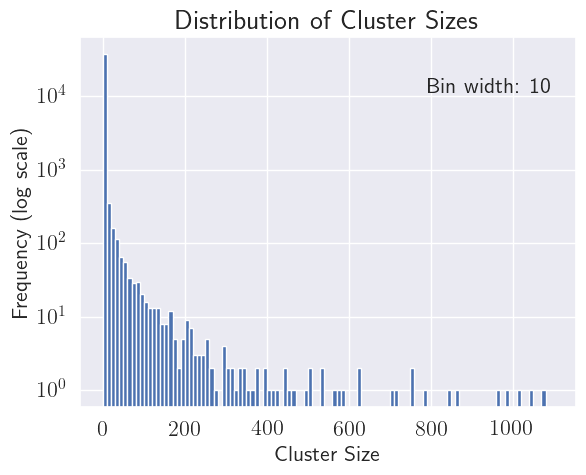

In [397]:
bin_width = 10
bins = np.arange(0, 1101, bin_width)

plt.hist(cluster_sizes, bins=bins, log=True)
plt.xlabel("Cluster Size")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Cluster Sizes")
plt.annotate(f"Bin width: {bin_width}", xy=(0.70, 0.85), xycoords="axes fraction")
if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/histogram-0-1100-sizes.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/histogram-0-1100-sizes.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

### IMPORTANT
**HERE CLUSTER SIZES ARE REDEFINED WHICH WILL CAUSE ISSUE WITH VIOLIN PLOTS ETC. LATER**

I am not going to fix it at the moment since this is code for use only in case, thus unimportant. If you want to run this notebook, here it will cause a major issue though.

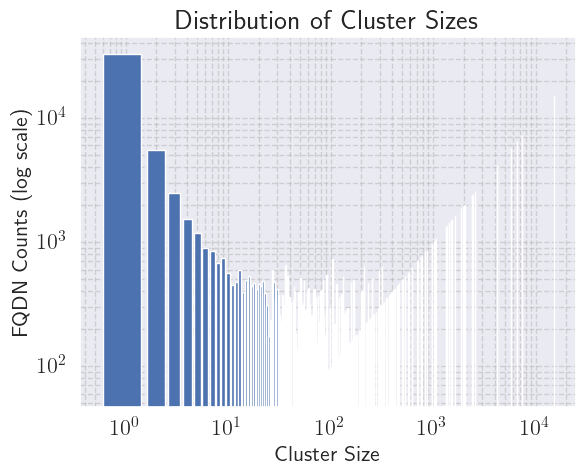

In [765]:
cluster_sizes = fqdns_per_cluster.index.values
fqdn_counts = fqdns_per_cluster.values

fig, ax = plt.subplots()

# Create a bar plot
ax.bar(cluster_sizes, fqdn_counts, log=True)
ax.set_xlabel("Cluster Size")
ax.set_ylabel("FQDN Counts (log scale)")
ax.set_title("Distribution of Cluster Sizes")
ax.set_yscale("log")
ax.set_xscale("log")

# Add a logarithmic grid with light grey color
ax.grid(True, which="both", linestyle="--", alpha=0.5, color=(0.7, 0.7, 0.7))

plt.show()

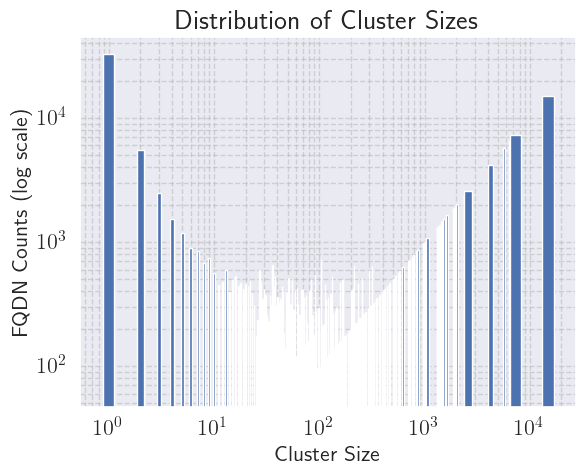

In [767]:
# Calculate the bar widths based on the distance between the cluster sizes on a logarithmic scale
log_cluster_sizes = np.log10(cluster_sizes)
bar_widths = np.diff(log_cluster_sizes)
bar_widths = np.append(
    bar_widths, bar_widths[-1]
)  # Add the last bar width to match the length

fig, ax = plt.subplots()

# Create a bar plot with custom bar widths
ax.bar(
    cluster_sizes,
    fqdn_counts,
    width=10**log_cluster_sizes * bar_widths * 0.8,
    log=True,
)
ax.set_xlabel("Cluster Size")
ax.set_ylabel("FQDN Counts (log scale)")
ax.set_title("Distribution of Cluster Sizes")
ax.set_xscale("log")

# Add a logarithmic grid with light grey color
ax.grid(True, which="both", linestyle="--", alpha=0.5, color=(0.7, 0.7, 0.7))

plt.show()

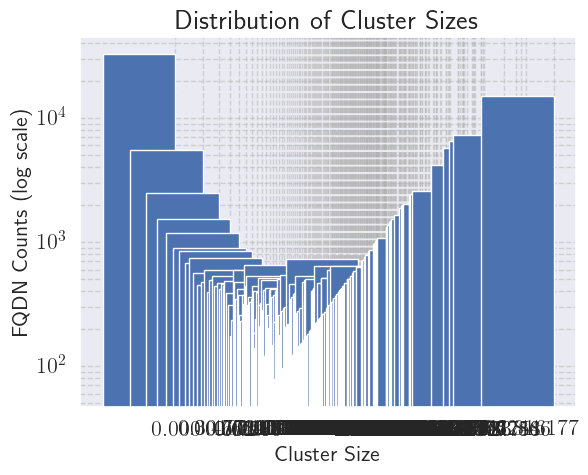

In [768]:
# Calculate the logarithm of the cluster sizes
log_cluster_sizes = np.log10(cluster_sizes)

# Set a constant bar width
bar_width = 0.8

# Calculate the adjusted bar positions to avoid overlaps
bar_positions = log_cluster_sizes - bar_width / 2

fig, ax = plt.subplots()

# Create a bar plot with custom bar positions and constant bar width
ax.bar(bar_positions, fqdn_counts, width=bar_width, log=True, align="center")

# Set the x-axis labels to the original cluster sizes and scale
ax.set_xticks(log_cluster_sizes)
# ax.set_xticklabels(cluster_sizes)

ax.set_xlabel("Cluster Size")
ax.set_ylabel("FQDN Counts (log scale)")
ax.set_title("Distribution of Cluster Sizes")


# Add a logarithmic grid with light grey color
ax.grid(True, which="both", linestyle="--", alpha=0.5, color=(0.7, 0.7, 0.7))

plt.show()

### Bubble plots

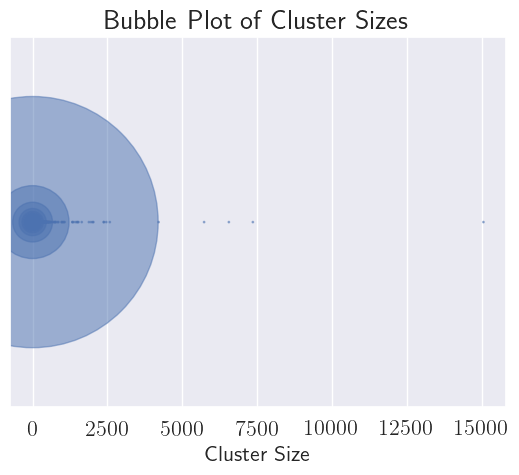

In [756]:
# Bubble plot
bubble_sizes = cluster_size_counts.values  # Adjust scaling factor as needed
plt.scatter(
    cluster_size_counts.index,
    np.zeros_like(cluster_size_counts),
    s=bubble_sizes,
    alpha=0.5,
)
plt.xlabel("Cluster Size")
plt.title("Bubble Plot of Cluster Sizes")
plt.gca().axes.get_yaxis().set_visible(False)
if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/bubble-overall-sizes.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/bubble-overall-sizes.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

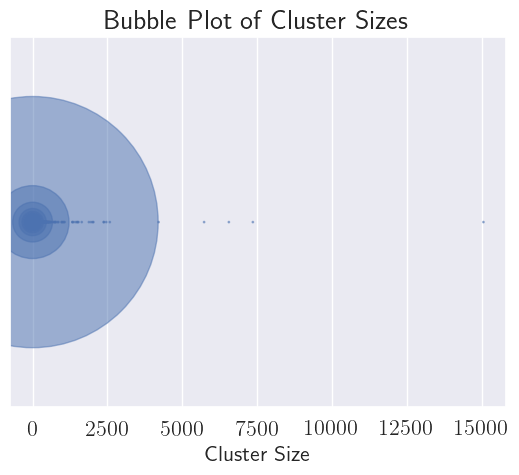

In [756]:
# Bubble plot
bubble_sizes = cluster_size_counts.values  # Adjust scaling factor as needed
plt.scatter(
    cluster_size_counts.index,
    np.zeros_like(cluster_size_counts),
    s=bubble_sizes,
    alpha=0.5,
)
plt.xlabel("Cluster Size")
plt.title("Bubble Plot of Cluster Sizes")
plt.gca().axes.get_yaxis().set_visible(False)
if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/bubble-overall-sizes.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/bubble-overall-sizes.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

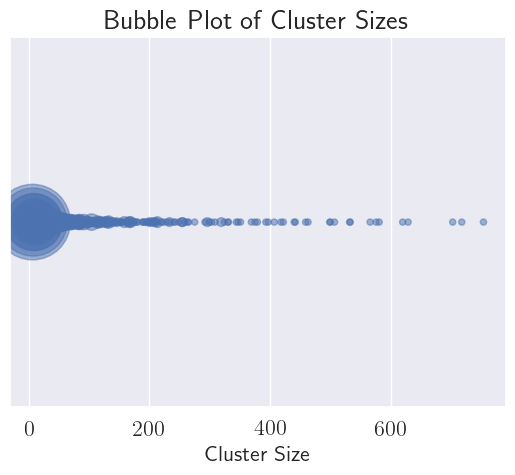

In [757]:
reduced_counts = cluster_size_counts[5:-30]
bubble_sizes = reduced_counts.values * 20  # Adjust the scaling factor as needed
plt.scatter(
    reduced_counts.index, np.zeros_like(reduced_counts), s=bubble_sizes, alpha=0.5
)
plt.xlabel("Cluster Size")
plt.title("Bubble Plot of Cluster Sizes")
plt.gca().axes.get_yaxis().set_visible(False)
if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/bubble-0-800-sizes.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/bubble-0-800-sizes.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

### Boxplots

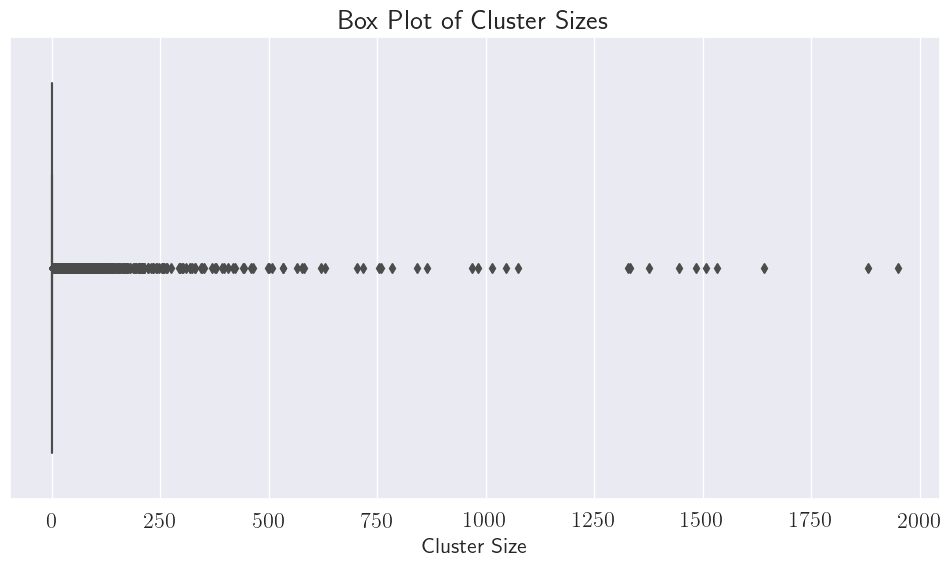

In [378]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=cluster_sizes[cluster_sizes < 2000])
plt.xlabel("Cluster Size")
plt.title("Box Plot of Cluster Sizes")
plt.show()

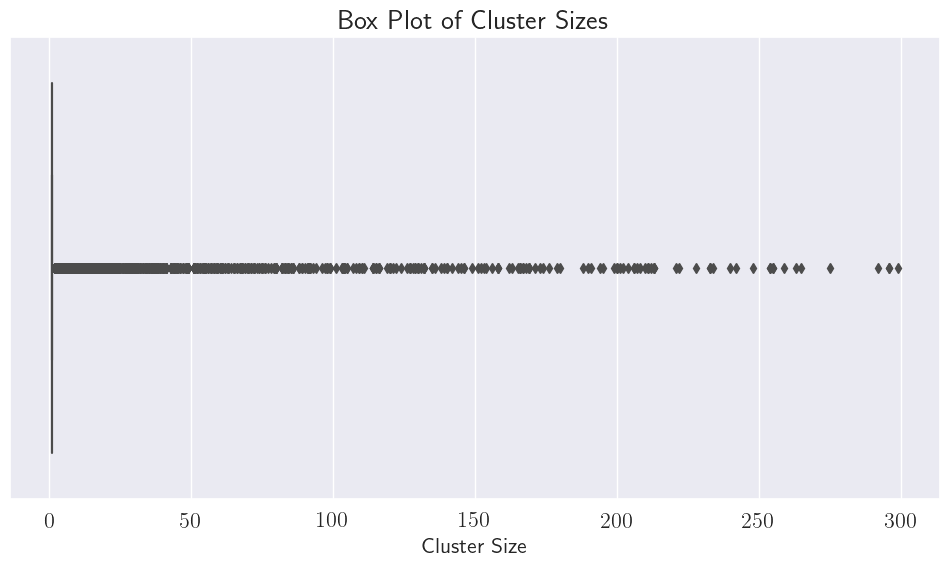

In [379]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=cluster_sizes[cluster_sizes < 300])
plt.xlabel("Cluster Size")
plt.title("Box Plot of Cluster Sizes")
plt.show()

### Violin plots

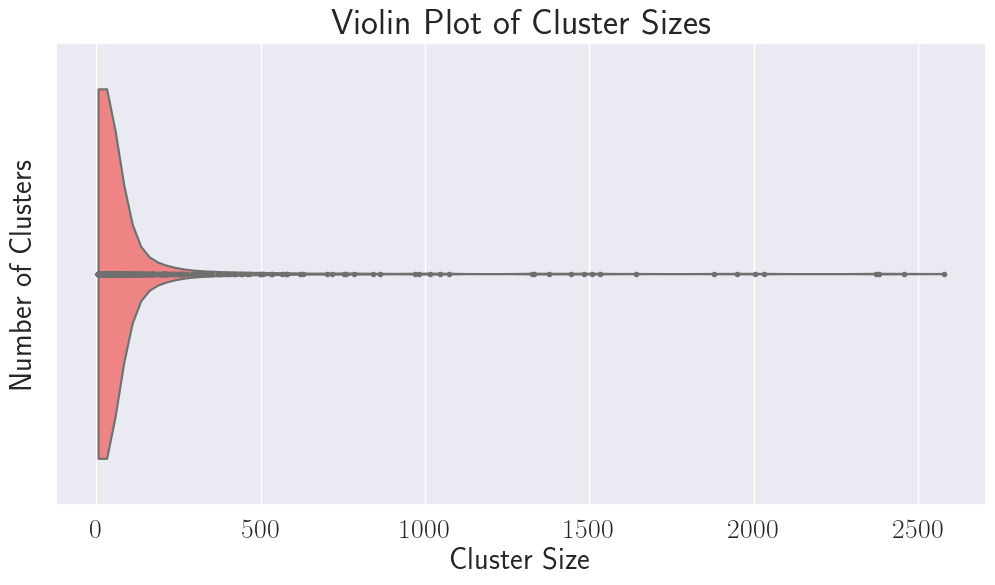

In [760]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    x=cluster_sizes[(cluster_sizes >= 5) & (cluster_sizes < 3000)],
    cut=0,
    color="#ff7373",
    inner="points",
)
plt.xlabel("Cluster Size", fontsize=22)
plt.ylabel("Number of Clusters", fontsize=22)
plt.title("Violin Plot of Cluster Sizes", fontsize=26)

ax.tick_params(labelsize=20)

if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/violin-5-3000-sizes.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/violin-5-3000-sizes.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

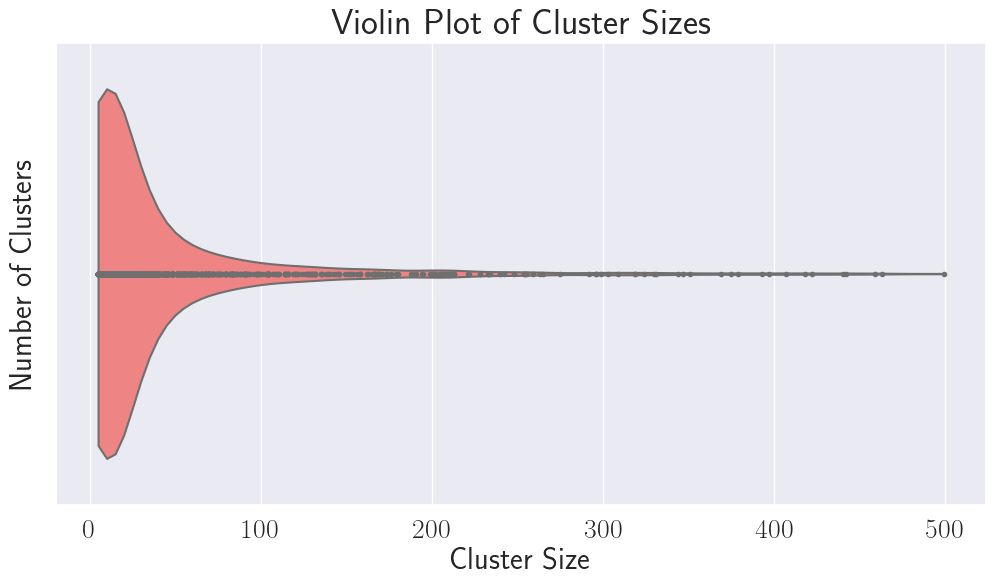

In [761]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    x=cluster_sizes[(cluster_sizes >= 5) & (cluster_sizes < 500)],
    cut=0,
    color="#ff7373",
    inner="points",
)
plt.xlabel("Cluster Size", fontsize=22)
plt.ylabel("Number of Clusters", fontsize=22)
plt.title("Violin Plot of Cluster Sizes", fontsize=26)

ax.tick_params(labelsize=20)
if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/violin-5-500-sizes.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/violin-5-500-sizes.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

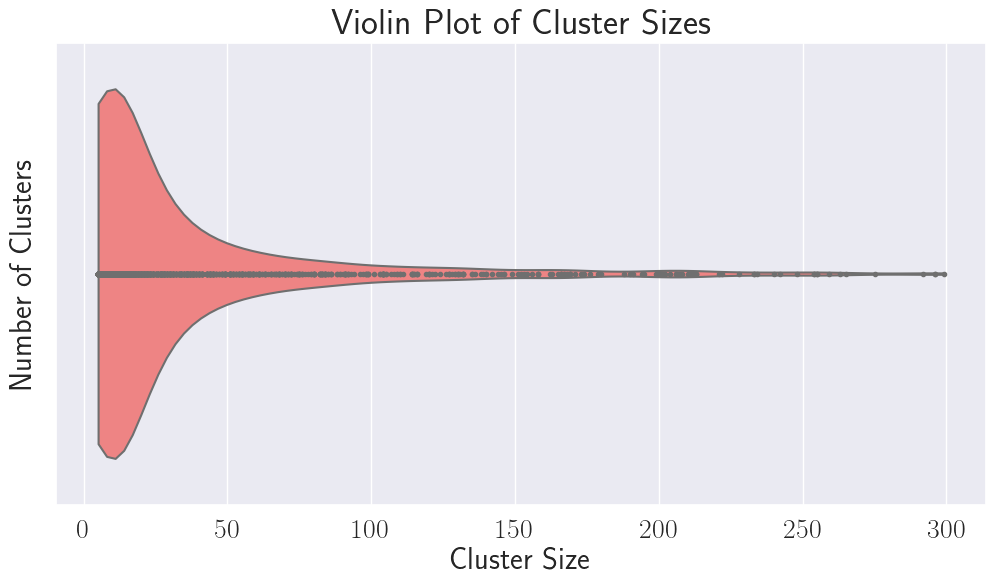

In [762]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    x=cluster_sizes[(cluster_sizes >= 5) & (cluster_sizes < 300)],
    cut=0,
    color="#ff7373",
    inner="points",
)
plt.xlabel("Cluster Size", fontsize=22)
plt.ylabel("Number of Clusters", fontsize=22)
plt.title("Violin Plot of Cluster Sizes", fontsize=26)

ax.tick_params(labelsize=20)

if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/violin-5-300-sizes.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/violin-5-300-sizes.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

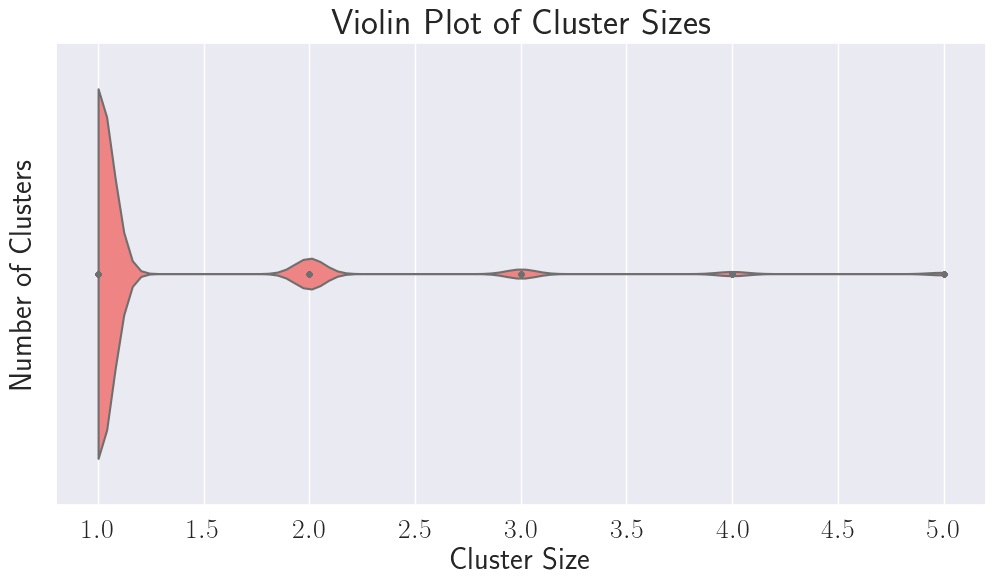

In [763]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    x=cluster_sizes[(cluster_sizes >= 0) & (cluster_sizes < 6)],
    cut=0,
    color="#ff7373",
    inner="points",
)
plt.xlabel("Cluster Size", fontsize=22)
plt.ylabel("Number of Clusters", fontsize=22)
plt.title("Violin Plot of Cluster Sizes", fontsize=26)

ax.tick_params(labelsize=20)
plt.show()

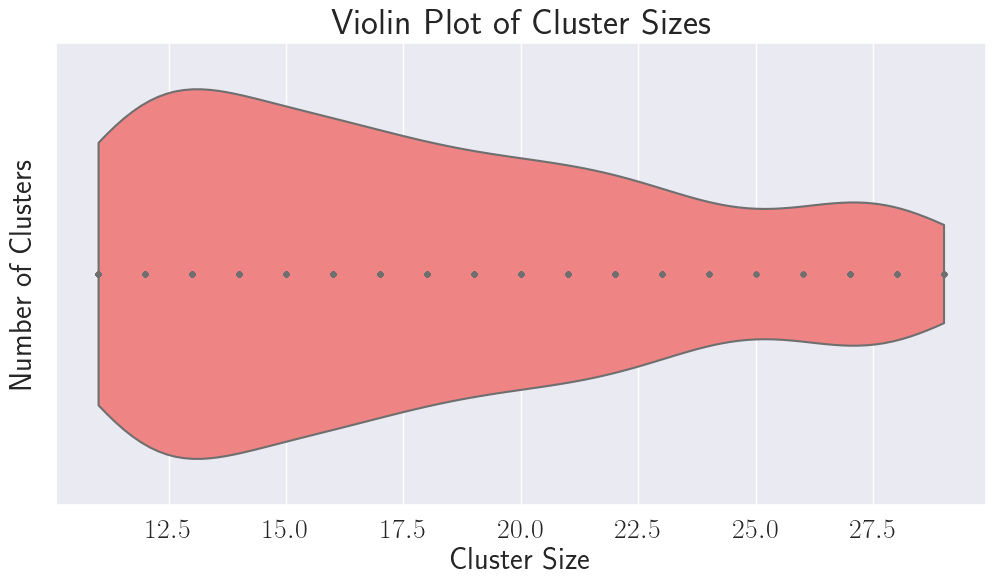

In [764]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    x=cluster_sizes[(cluster_sizes > 10) & (cluster_sizes < 30)],
    cut=0,
    color="#ff7373",
    inner="points",
)
plt.xlabel("Cluster Size", fontsize=22)
plt.ylabel("Number of Clusters", fontsize=22)
plt.title("Violin Plot of Cluster Sizes", fontsize=26)

ax.tick_params(labelsize=20)
plt.show()

### Swarm & Strip plots

<Axes: xlabel='category'>

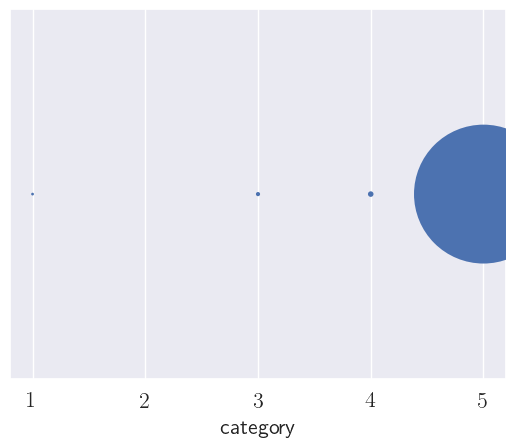

In [567]:
df = pd.DataFrame(
    {"category": [1, 3, 4, 5], "value": [1, 3, 2, 4], "size": [10, 20, 5, 10]}
)

sns.swarmplot(x="category", data=df, s=np.array([2, 3, 4, 100], dtype=np.float32))

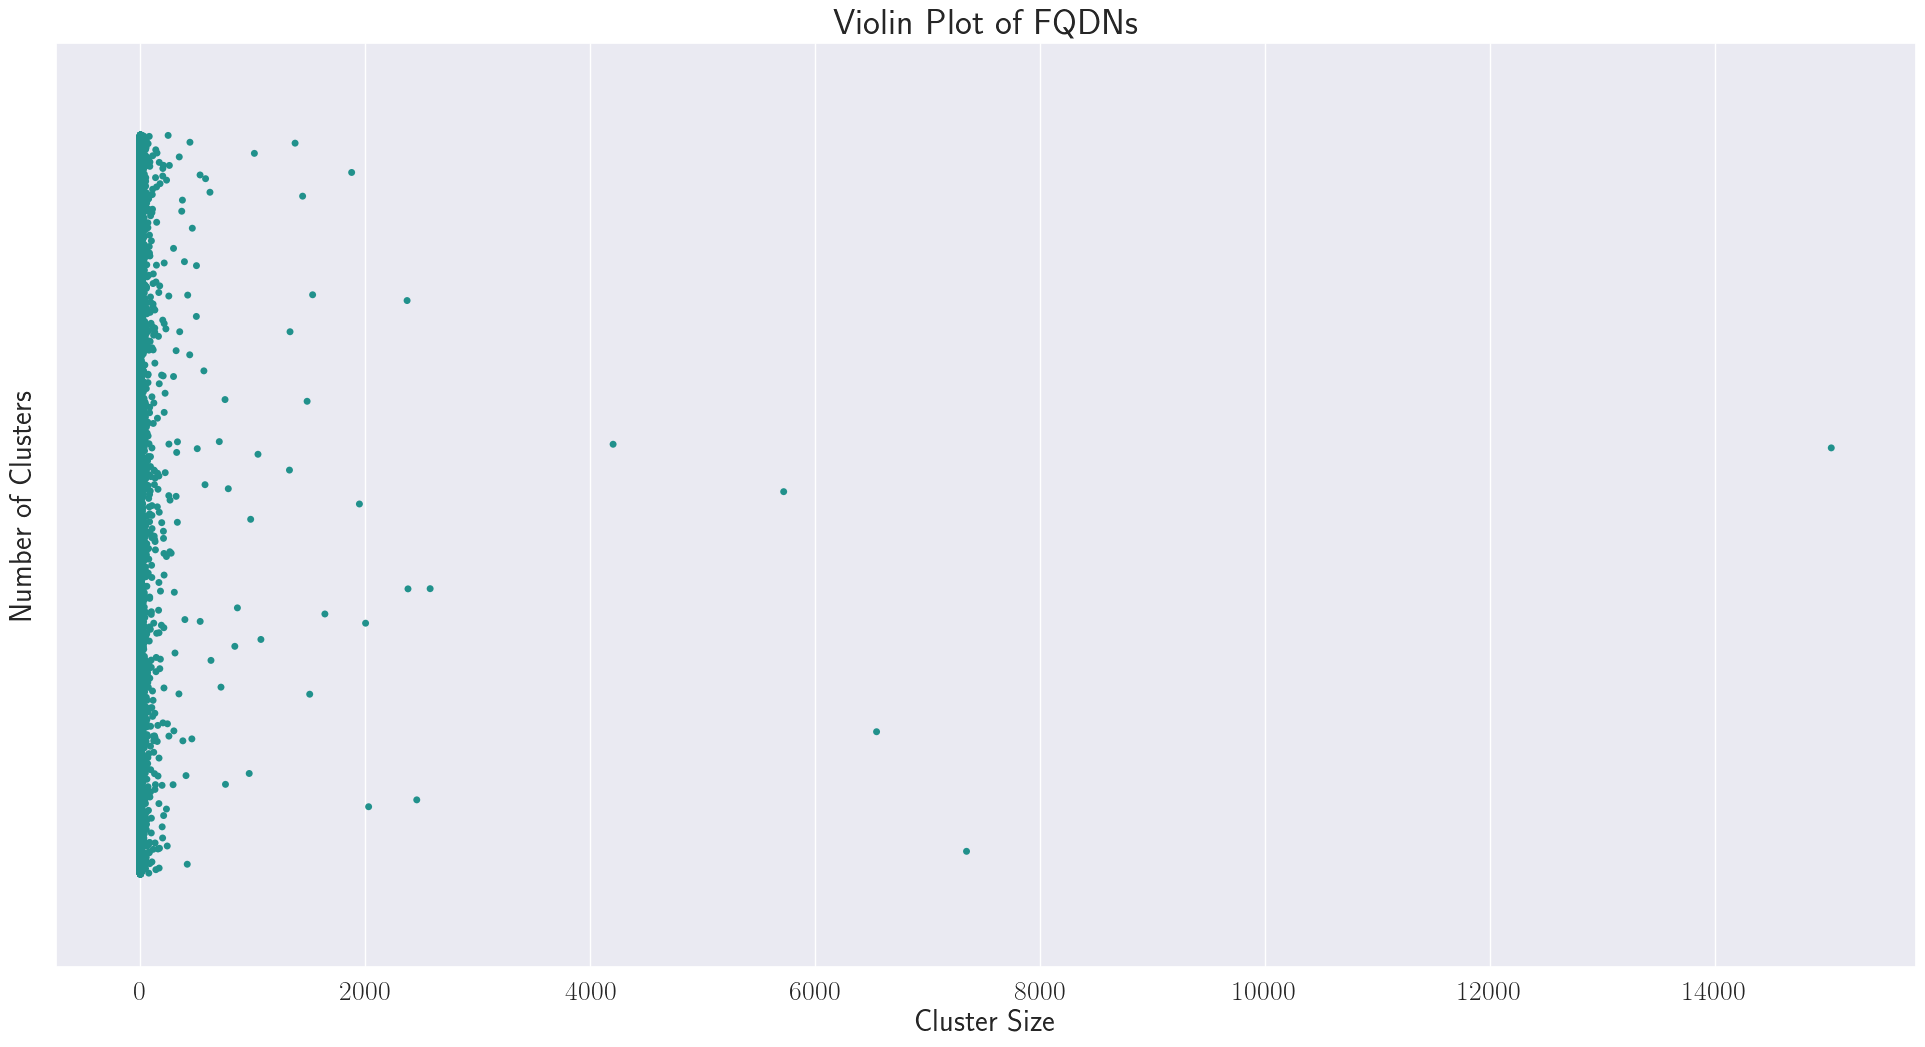

In [788]:
plt.figure(figsize=(24, 12))
ax = sns.stripplot(x=cluster_sizes, palette="viridis", jitter=0.4)
plt.xlabel("Cluster Size", fontsize=22)
plt.ylabel("Number of Clusters", fontsize=22)
plt.title("Violin Plot of FQDNs", fontsize=26)

ax.tick_params(labelsize=20)

# Add a logarithmic grid with light grey color
# ax.grid(True, which="both", linestyle="--", alpha=0.5, color=(0.7, 0.7, 0.7))

plt.show()

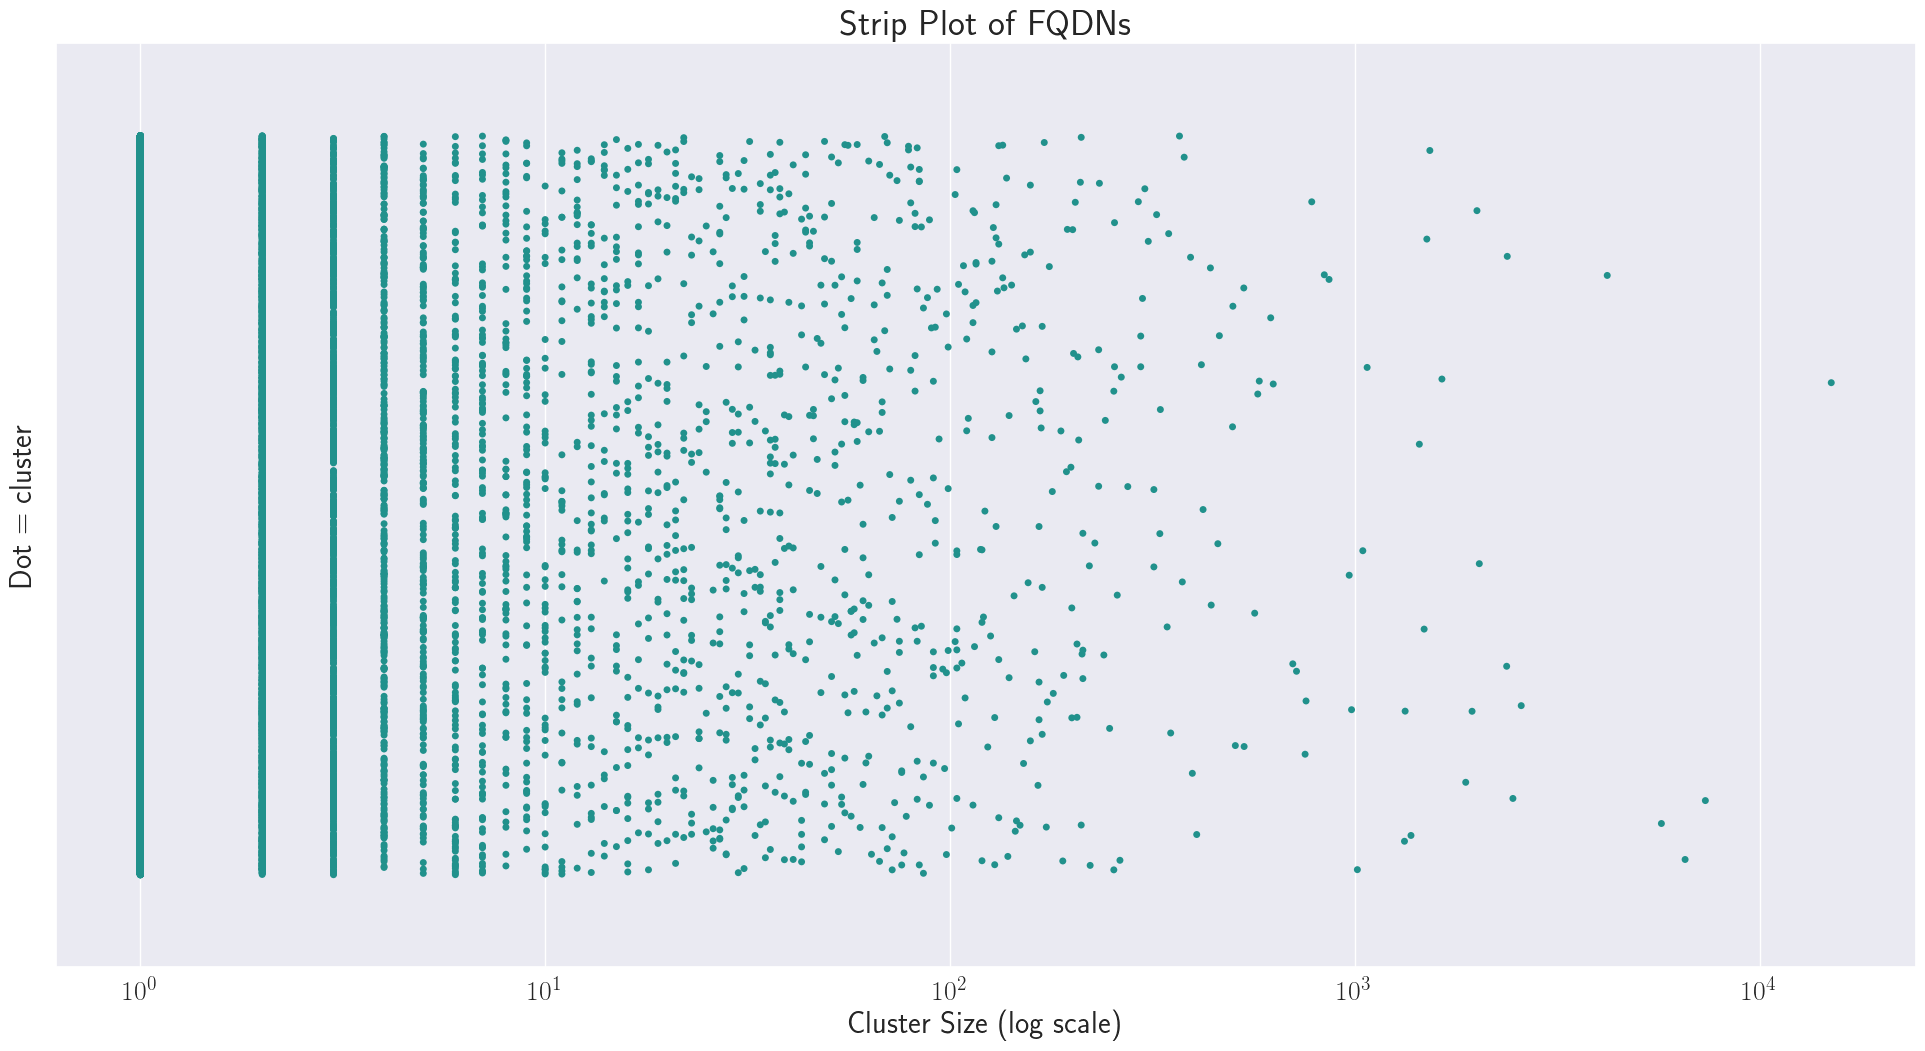

In [797]:
plt.figure(figsize=(24, 12))
ax = sns.stripplot(x=cluster_sizes, palette="viridis", jitter=0.4)
plt.xlabel("Cluster Size (log scale)", fontsize=22)
plt.ylabel("Dot = cluster", fontsize=22)
plt.title("Strip Plot of FQDNs", fontsize=26)

ax.set_xscale("log")
ax.tick_params(labelsize=20)

# Add a logarithmic grid with light grey color
# ax.grid(True, which="both", linestyle="--", alpha=0.5, color=(0.7, 0.7, 0.7))

if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/strip-cluster-log.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/strip-cluster-log.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )

plt.show()

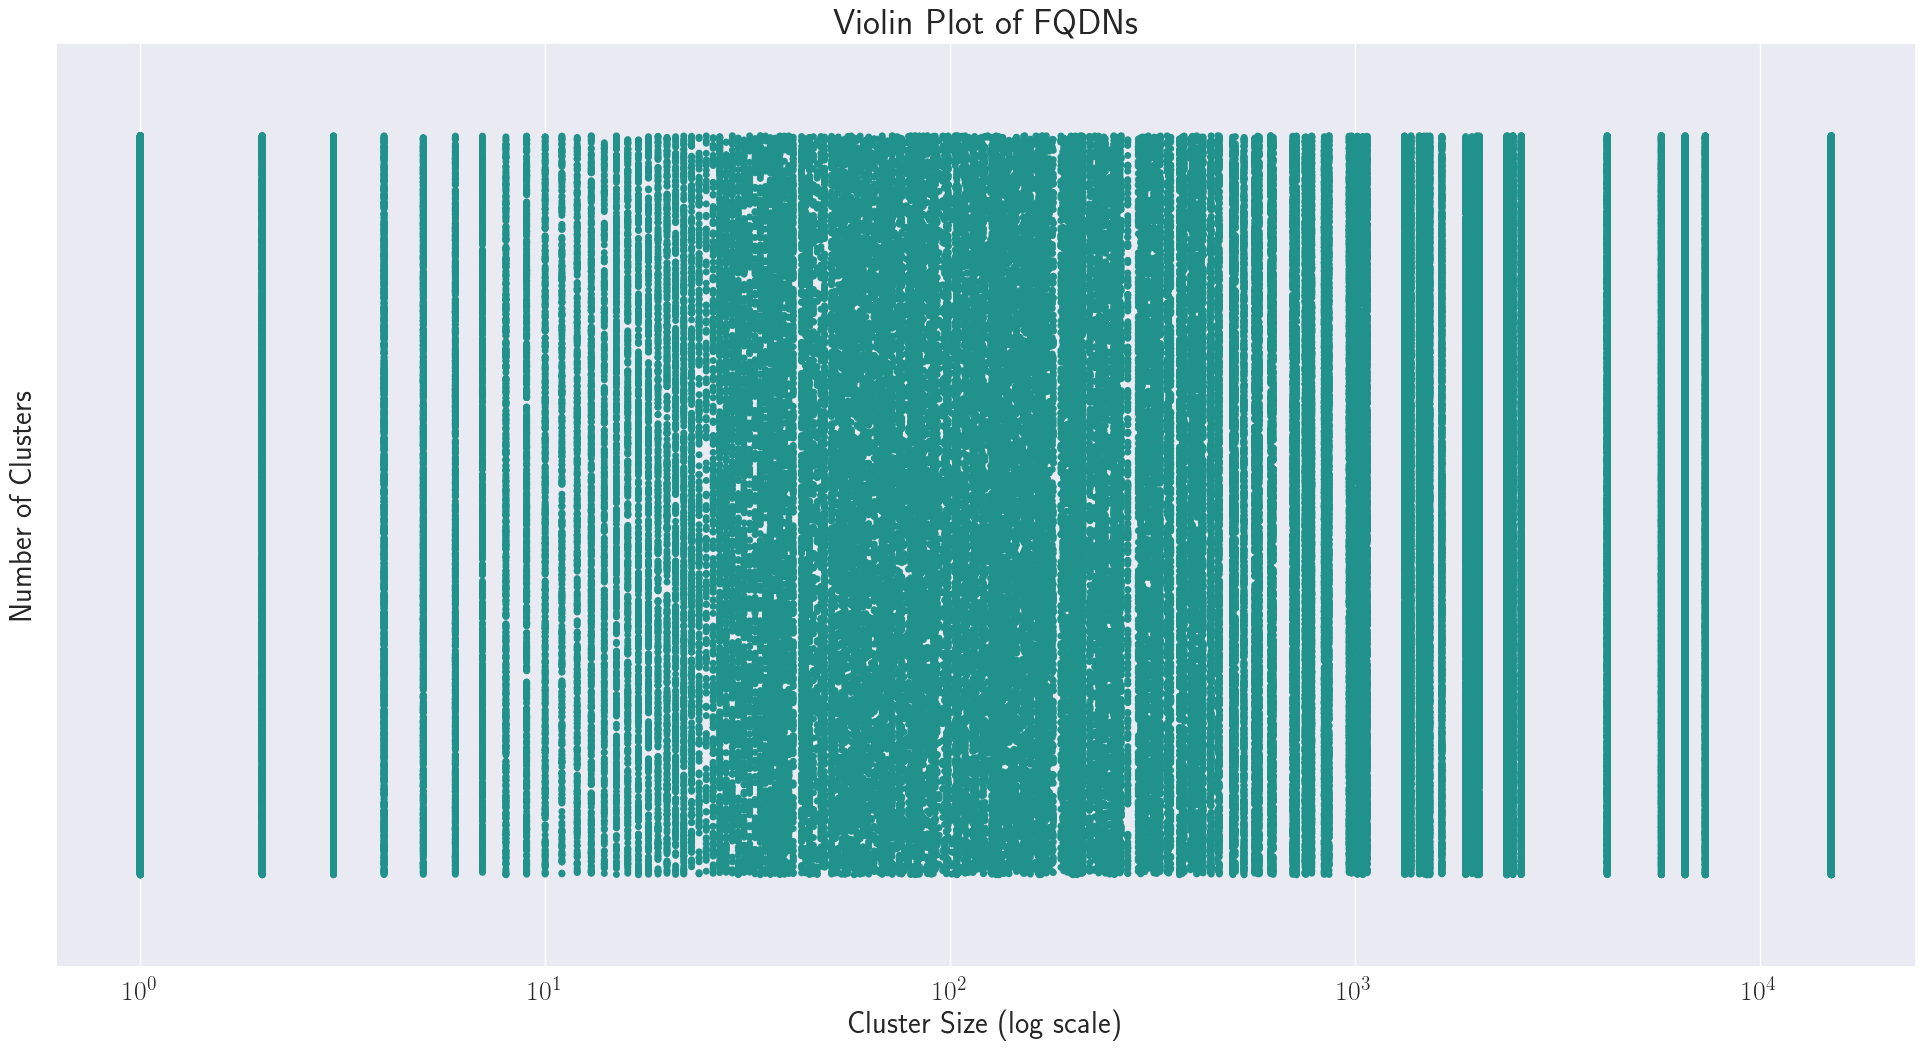

In [794]:
plt.figure(figsize=(24, 12))
ax = sns.stripplot(x=fqdns_per_cluster_repeated, palette="viridis", jitter=0.4)
plt.xlabel("Cluster Size (log scale)", fontsize=22)
plt.ylabel("Number of Clusters", fontsize=22)
plt.title("Violin Plot of FQDNs", fontsize=26)

ax.set_xscale("log")
ax.tick_params(labelsize=20)

# Add a logarithmic grid with light grey color
# ax.grid(True, which="both", linestyle="--", alpha=0.5, color=(0.7, 0.7, 0.7))

if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/strip-fqdns-log.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/strip-fqdns-log.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

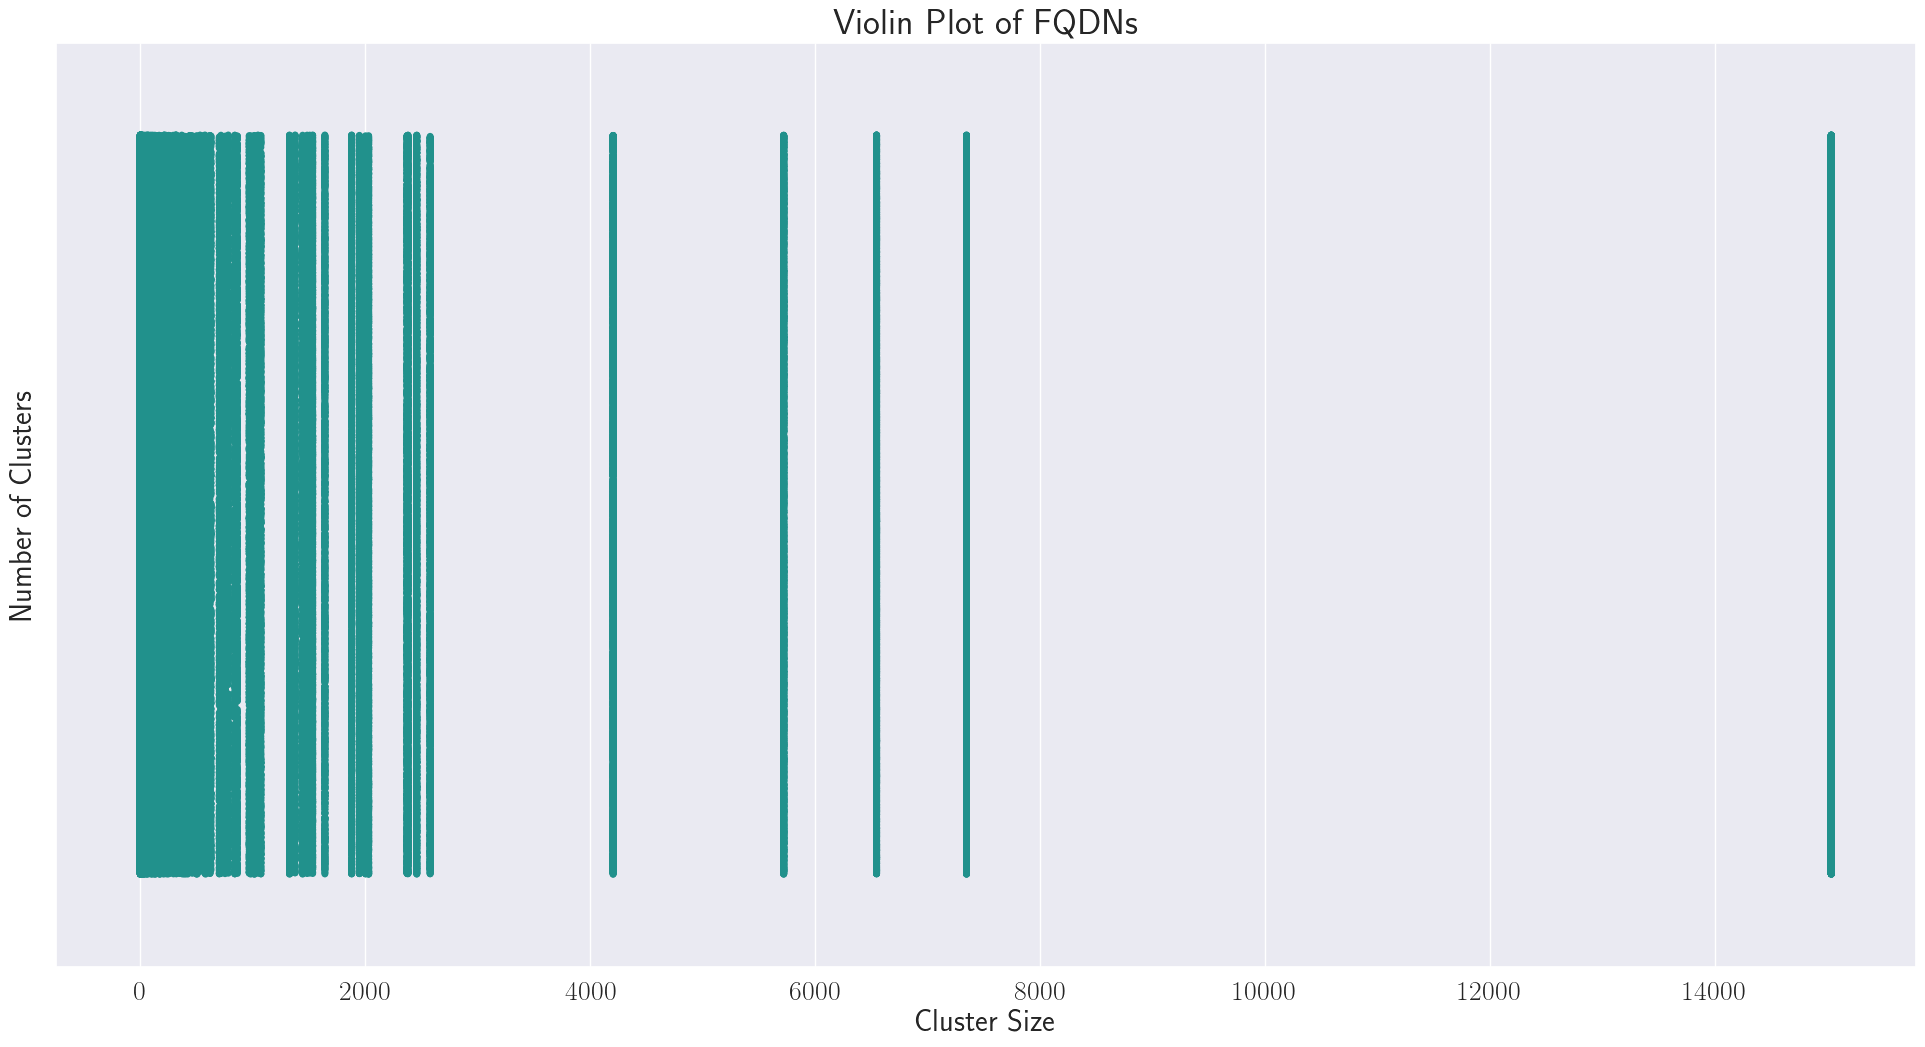

In [800]:
plt.figure(figsize=(24, 12))
ax = sns.stripplot(x=fqdns_per_cluster_repeated, palette="viridis", jitter=0.4)
plt.xlabel("Cluster Size", fontsize=22)
plt.ylabel("Number of Clusters", fontsize=22)
plt.title("Violin Plot of FQDNs", fontsize=26)

ax.tick_params(labelsize=20)

plt.show()